In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 kB 7.4 MB/s eta 0:00:0000:01
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel ke

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [8]:
def read_image(path):
  # TODO: Open the image in RGB format and convert into numpy array
    with Image.open('/Users/liuaaron/Desktop/EC506/CS506-Spring2023/labs/04-lab/image.png').convert('RGB') as img:
        image = np.array(img)

    image = image.astype(np.float32) / 255.0
    
    return image
  

In [9]:
image = read_image('image.jpg')
shape = image.shape
print('Image shape:', shape)


Image shape: (382, 774, 3)


In [11]:
original_bytes = image.nbytes
print ("The space (in bytes) needed to store this image is", original_bytes)

The space (in bytes) needed to store this image is 3548016


In [12]:
def SVD_channels(image):
  # TODO: Separate the channels of the image
  image_red = image[:,:,0]
  image_green = image[:,:,1]
  image_blue = image[:,:,2]

  # Perform SVD on each channel
  U_r, S_r, V_r = np.linalg.svd(image_red, full_matrices=False)
  U_g, S_g, V_g = np.linalg.svd(image_green, full_matrices=False)
  U_b, S_b, V_b = np.linalg.svd(image_blue, full_matrices=False)
  
  return U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b

In [13]:
U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)
bytes_to_be_stored = sum([matrix.nbytes for matrix in [U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b]])
print ("The matrices that we store have total size (in bytes):", bytes_to_be_stored)

The matrices that we store have total size (in bytes): 5303688


In [14]:
def TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k):
  # TODO: Use only top K eignevectors. Top K in U, S, V in all channels

    U_r_k = U_r[:, :k]
    S_r_k = S_r[:k]
    V_r_k = V_r[:k, :]

    U_g_k = U_g[:, :k]
    S_g_k = S_g[:k]
    V_g_k = V_g[:k, :]

    U_b_k = U_b[:, :k]
    S_b_k = S_b[:k]
    V_b_k = V_b[:k, :]

    return U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k

In [15]:
U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k=10)

compressed_bytes = sum([matrix.nbytes for matrix in [U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k]])
print ("The compressed matrices that we store now have total size (in bytes):", compressed_bytes)

The compressed matrices that we store now have total size (in bytes): 138840


In [16]:
ratio = compressed_bytes / original_bytes
print ("The compression ratio between the original image size and the total size of the compressed factors is", ratio)

The compression ratio between the original image size and the total size of the compressed factors is 0.039131728830986104


In [23]:
def reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k):
  # TODO: Reconstruct the image from compressed U, S, V matrices.

    image_red_approx = U_r_k @ np.diag(S_r_k) @ V_r_k
    image_green_approx = U_g_k @ np.diag(S_g_k) @ V_g_k
    image_blue_approx = U_b_k @ np.diag(S_b_k) @ V_b_k

    # Combine the color channels into a single image
    image_approx = np.stack([image_red_approx, image_green_approx, image_blue_approx], axis=-1)

    return image_approx

In [24]:
image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

image_reconstructed[image_reconstructed < 0] = 0
image_reconstructed[image_reconstructed > 1] = 1

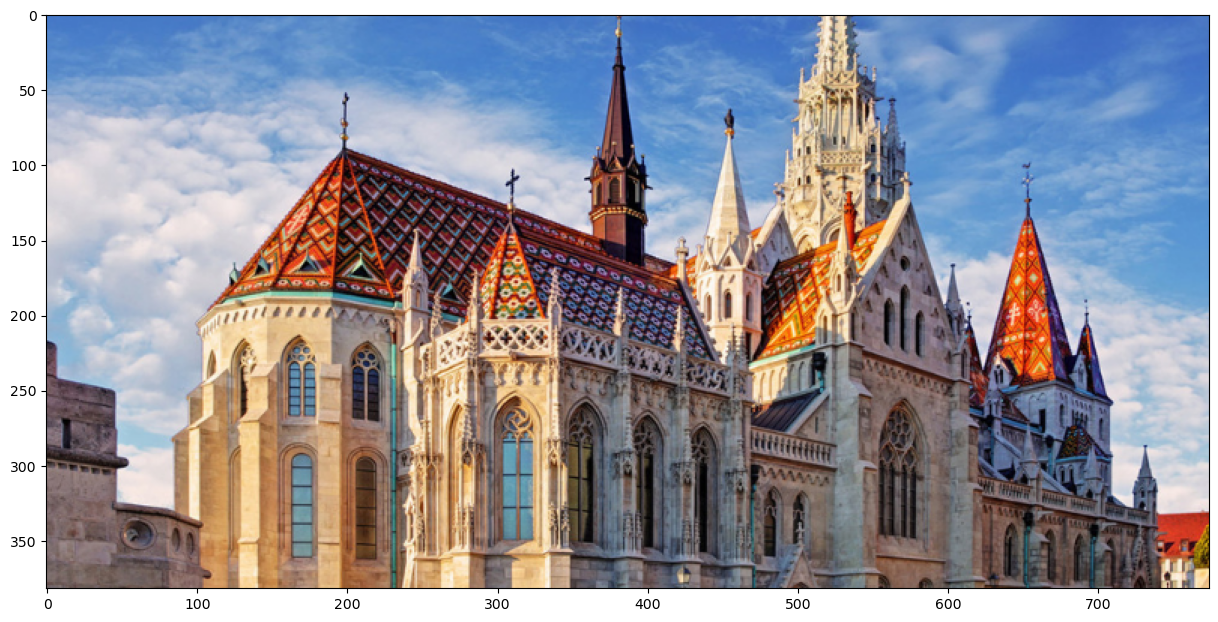

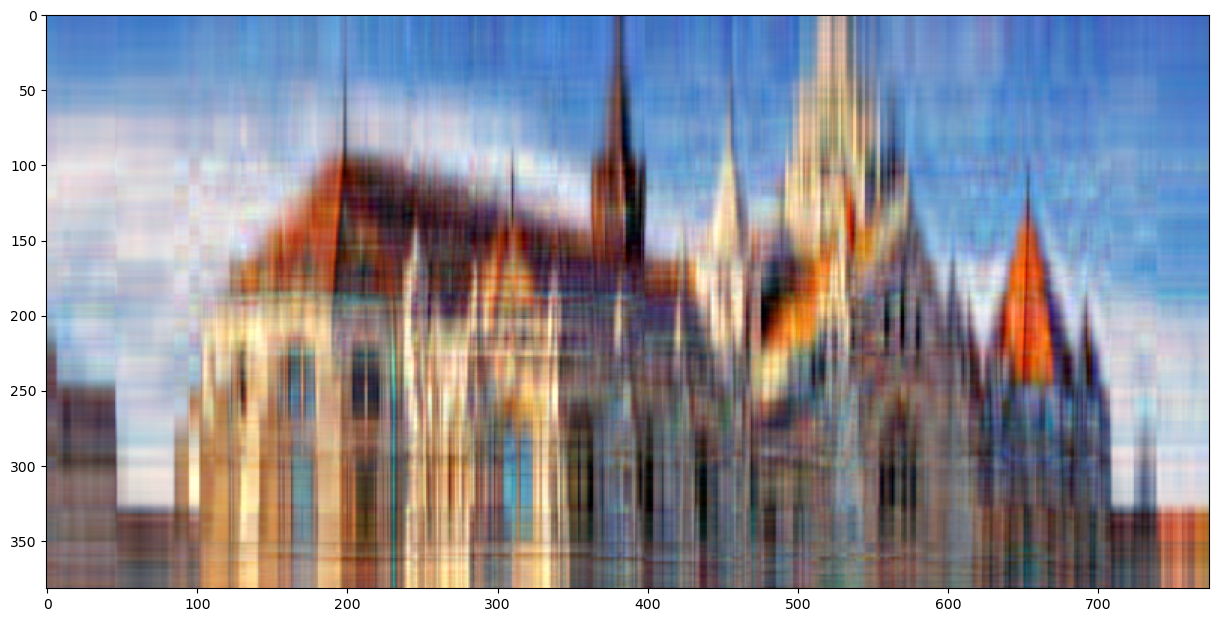

In [25]:
# fig = plt.figure(figsize=(15, 10))
# a = fig.add_subplot(1, 1, 1)
plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.figure(figsize=(15, 10))
plt.imshow(image_reconstructed)
# a.set_title('Castle hill, compressed image using the best rank-{} approximation'.format(k))
# plt.show()

In [26]:
@interact(k=widgets.IntSlider(min=0, max=300, step=5))
def image_compressor(k):
  image = read_image('image.jpg')
  U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b = SVD_channels(image)

  U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k = TopK_Eigen(U_r, S_r, V_r, U_g, S_g, V_g, U_b, S_b, V_b, k)

  image_reconstructed = reconstruct(U_r_k, S_r_k, V_r_k, U_g_k, S_g_k, V_g_k, U_b_k, S_b_k, V_b_k)

  image_reconstructed[image_reconstructed < 0] = 0
  image_reconstructed[image_reconstructed > 1] = 1

  plt.figure(figsize=(15, 10))

  plt.imshow(image_reconstructed)

# interact(image_compressor);

interactive(children=(IntSlider(value=0, description='k', max=300, step=5), Output()), _dom_classes=('widget-i…